In [3]:
import gc # 清理内存
import os
import numpy as np
import pandas as pd

### 数据清洗

In [2]:
pd.read_excel('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/Data_Dictionary.xlsx',header=2,sheet_name='train')

,Columns,Description
0,card_id,Unique card identifier
1,first_active_month,"'YYYY-MM', month of first purchase"
2,feature_1,Anonymized card categorical feature
3,feature_2,Anonymized card categorical feature
4,feature_3,Anonymized card categorical feature
5,target,Loyalty numerical score calculated 2 months af...


In [4]:
train = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/train.csv')
test = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/test.csv')

In [5]:
train.shape,test.shape

((201917, 6), (123623, 5))

In [6]:
train.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201917 entries, 0 to 201916
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   first_active_month  201917 non-null  object 
 1   card_id             201917 non-null  object 
 2   feature_1           201917 non-null  int64  
 3   feature_2           201917 non-null  int64  
 4   feature_3           201917 non-null  int64  
 5   target              201917 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 9.2+ MB


- 数据质量分析

In [9]:
train['card_id'].nunique()==train.shape[0]

True

In [10]:
test['card_id'].nunique()==test.shape[0]

True

In [11]:
# 缺失值
train.isnull().sum()

first_active_month    0
card_id               0
feature_1             0
feature_2             0
feature_3             0
target                0
dtype: int64

In [12]:
test.isnull().sum()

first_active_month    1
card_id               0
feature_1             0
feature_2             0
feature_3             0
dtype: int64

In [13]:
# 异常值
statistics = train['target'].describe()

In [14]:
statistics

count    201917.000000
mean         -0.393636
std           3.850500
min         -33.219281
25%          -0.883110
50%          -0.023437
75%           0.765453
max          17.965068
Name: target, dtype: float64

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='target', ylabel='Count'>

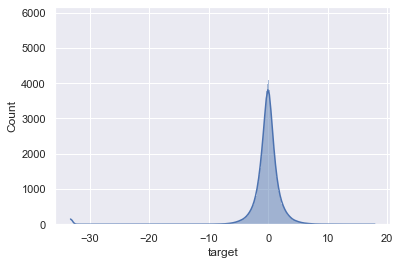

In [16]:
# 概率密度直方图
sns.set()
sns.histplot(train['target'],kde=True)

In [17]:
(train['target']<-30).sum()

2207

In [18]:
# 使用3sigam原则识别异常值
statistics.loc['mean']-3*statistics.loc['std']

-11.945136285536126

- 规律一致性分析

In [19]:
# 单变量分析
features = ['first_active_month','feature_1','feature_2','feature_3']

train_count = train.shape[0]
test_count = test.shape[0]

In [20]:
# 不同取值水平汇总后排序再除以样本总数
train['first_active_month'].value_counts().sort_index()/train_count

2011-11    0.000040
2011-12    0.000010
2012-02    0.000035
2012-03    0.000050
2012-04    0.000089
             ...   
2017-10    0.067825
2017-11    0.064036
2017-12    0.050367
2018-01    0.000168
2018-02    0.000005
Name: first_active_month, Length: 75, dtype: float64

<AxesSubplot:>

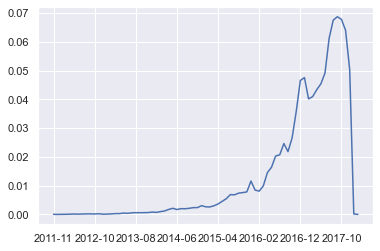

In [21]:
(train['first_active_month'].value_counts().sort_index()/train_count).plot()

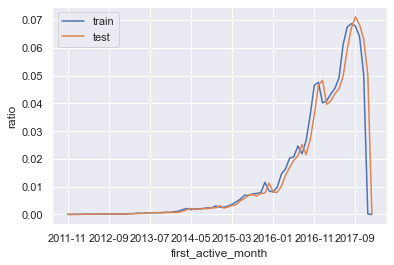

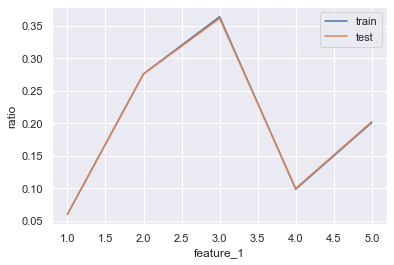

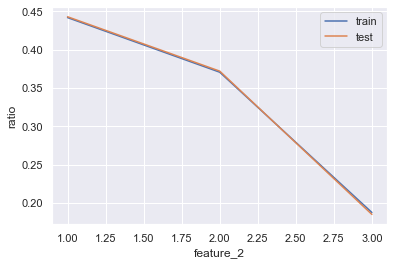

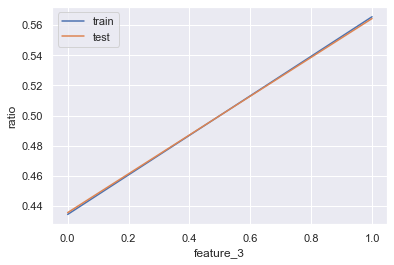

In [22]:
for feature in features:
    (train[feature].value_counts().sort_index()/train_count).plot()
    (test[feature].value_counts().sort_index()/test_count).plot()
    plt.legend(['train','test'])
    plt.xlabel(feature)
    plt.ylabel('ratio')
    plt.show()

In [23]:
# 多变量联合分布
def combine_feature(df):
    cols = df.columns
    feature1 = df[cols[0]].astype(str).values.tolist()
    feature2 = df[cols[1]].astype(str).values.tolist()
    return pd.Series([feature1[i]+'&'+feature2[i] for i in range(df.shape[0])])

In [32]:
# 简单测试
cols = [features[0],features[1]]
cols

['first_active_month', 'feature_1']

In [33]:
train_com = combine_feature(train[cols])
train_com

0         2017-06&5
1         2017-01&4
2         2016-08&2
3         2017-09&4
4         2017-11&1
            ...    
201912    2017-09&3
201913    2015-10&3
201914    2017-08&4
201915    2016-07&3
201916    2017-07&3
Length: 201917, dtype: object

In [34]:
# 计算占比
train_dis = train_com.value_counts().sort_index()/train_count
train_dis

2011-11&3    0.000040
2011-12&3    0.000010
2012-02&3    0.000035
2012-03&3    0.000050
2012-04&3    0.000089
               ...   
2018-01&2    0.000054
2018-01&3    0.000020
2018-01&4    0.000045
2018-01&5    0.000015
2018-02&1    0.000005
Length: 239, dtype: float64

In [35]:
test_dis = combine_feature(test[cols]).value_counts().sort_index()/test_count
test_dis

2011-11&3    0.000024
2011-12&3    0.000016
2012-01&3    0.000008
2012-02&3    0.000032
2012-03&3    0.000081
               ...   
2018-01&2    0.000089
2018-01&3    0.000016
2018-01&4    0.000040
2018-01&5    0.000024
nan&5        0.000008
Length: 239, dtype: float64

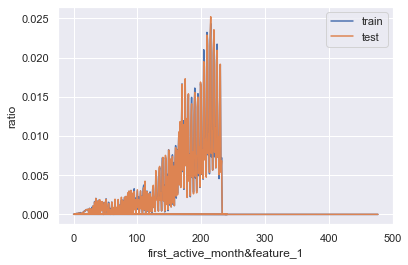

In [36]:
# 创建新的index
index_dis = pd.Series(train_dis.index.tolist() + test_dis.index.tolist()).drop_duplicates().sort_values()

# 对缺失值填补为0
(index_dis.map(train_dis).fillna(0)).plot()
(index_dis.map(test_dis).fillna(0)).plot()

# 绘图
plt.legend(['train','test'])
plt.xlabel('&'.join(cols))
plt.ylabel('ratio')
plt.show()

['first_active_month', 'feature_1']


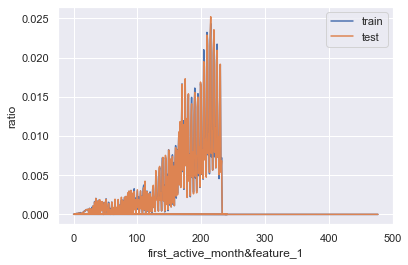

['first_active_month', 'feature_2']


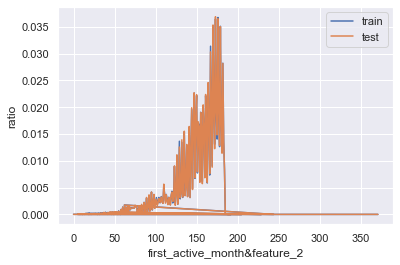

['first_active_month', 'feature_3']


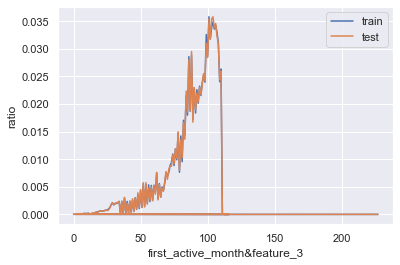

['feature_1', 'feature_2']


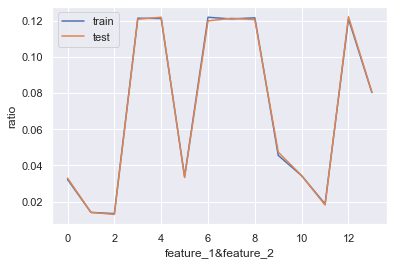

['feature_1', 'feature_3']


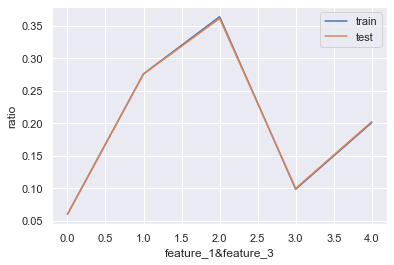

['feature_2', 'feature_3']


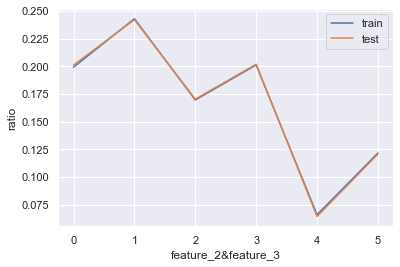

In [37]:
n = len(features)
for i in range(n-1):
    for j in range(i+1, n):
        cols = [features[i], features[j]]
        print(cols)
        train_dis = combine_feature(train[cols]).value_counts().sort_index()/train_count
        test_dis = combine_feature(test[cols]).value_counts().sort_index()/test_count
        index_dis = pd.Series(train_dis.index.tolist() + test_dis.index.tolist()).drop_duplicates().sort_values()
        (index_dis.map(train_dis).fillna(0)).plot()
        (index_dis.map(test_dis).fillna(0)).plot()
        plt.legend(['train','test'])
        plt.xlabel('&'.join(cols))
        plt.ylabel('ratio')
        plt.show()

- 商户数据解读与探索

In [38]:
merchant = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/merchants.csv',header=0)

In [39]:
merchant.head()

,merchant_id,merchant_group_id,merchant_category_id,subsector_id,numerical_1,numerical_2,category_1,most_recent_sales_range,most_recent_purchases_range,avg_sales_lag3,...,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12,category_4,city_id,state_id,category_2
0,M_ID_838061e48c,8353,792,9,-0.057471,-0.057471,N,E,E,-0.40,...,-2.25,18.666667,6,-2.32,13.916667,12,N,242,9,1.0
1,M_ID_9339d880ad,3184,840,20,-0.057471,-0.057471,N,E,E,-0.72,...,-0.74,1.291667,6,-0.57,1.687500,12,N,22,16,1.0
2,M_ID_e726bbae1e,447,690,1,-0.057471,-0.057471,N,E,E,-82.13,...,-82.13,260.000000,2,-82.13,260.000000,2,N,-1,5,5.0
3,M_ID_a70e9c5f81,5026,792,9,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,4.666667,6,NaN,3.833333,12,Y,-1,-1,NaN
4,M_ID_64456c37ce,2228,222,21,-0.057471,-0.057471,Y,E,E,NaN,...,NaN,0.361111,6,NaN,0.347222,12,Y,-1,-1,NaN


In [41]:
merchant.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334696 entries, 0 to 334695
Data columns (total 22 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   merchant_id                  334696 non-null  object 
 1   merchant_group_id            334696 non-null  int64  
 2   merchant_category_id         334696 non-null  int64  
 3   subsector_id                 334696 non-null  int64  
 4   numerical_1                  334696 non-null  float64
 5   numerical_2                  334696 non-null  float64
 6   category_1                   334696 non-null  object 
 7   most_recent_sales_range      334696 non-null  object 
 8   most_recent_purchases_range  334696 non-null  object 
 9   avg_sales_lag3               334683 non-null  float64
 10  avg_purchases_lag3           334696 non-null  float64
 11  active_months_lag3           334696 non-null  int64  
 12  avg_sales_lag6               334683 non-null  float64
 13 

In [42]:
merchant.shape,merchant['merchant_id'].nunique()

((334696, 22), 334633)

In [43]:
merchant.isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
numerical_1                        0
numerical_2                        0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
avg_sales_lag3                    13
avg_purchases_lag3                 0
active_months_lag3                 0
avg_sales_lag6                    13
avg_purchases_lag6                 0
active_months_lag6                 0
avg_sales_lag12                   13
avg_purchases_lag12                0
active_months_lag12                0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [44]:
category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'category_4', 'city_id', 'state_id', 'category_2']
numeric_cols = ['numerical_1', 'numerical_2',
     'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']

# 检验特征是否划分完全
assert len(category_cols) + len(numeric_cols) == merchant.shape[1]

In [45]:
# 离散型变量情况
merchant[category_cols].nunique()

merchant_id                    334633
merchant_group_id              109391
merchant_category_id              324
subsector_id                       41
category_1                          2
most_recent_sales_range             5
most_recent_purchases_range         5
category_4                          2
city_id                           271
state_id                           25
category_2                          5
dtype: int64

In [46]:
merchant[category_cols].dtypes

merchant_id                     object
merchant_group_id                int64
merchant_category_id             int64
subsector_id                     int64
category_1                      object
most_recent_sales_range         object
most_recent_purchases_range     object
category_4                      object
city_id                          int64
state_id                         int64
category_2                     float64
dtype: object

In [47]:
merchant[category_cols].isnull().sum()

merchant_id                        0
merchant_group_id                  0
merchant_category_id               0
subsector_id                       0
category_1                         0
most_recent_sales_range            0
most_recent_purchases_range        0
category_4                         0
city_id                            0
state_id                           0
category_2                     11887
dtype: int64

In [48]:
merchant['category_2'].unique()

array([ 1.,  5., nan,  2.,  3.,  4.])

In [49]:
merchant['category_2'] = merchant['category_2'].fillna(-1) # 对缺失值标注

In [50]:
# 离散型变量编码
# 字典编码函数
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)),index=value)).values

In [51]:
merchant['category_1']

0         N
1         N
2         N
3         Y
4         Y
         ..
334691    N
334692    Y
334693    N
334694    Y
334695    N
Name: category_1, Length: 334696, dtype: object

In [52]:
change_object_cols(merchant['category_1'])

array([0, 0, 0, ..., 0, 1, 0])

In [53]:
for col in ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']:
    merchant[col] = change_object_cols(merchant[col])

In [54]:
# 连续型变量
merchant[numeric_cols].dtypes

numerical_1            float64
numerical_2            float64
avg_sales_lag3         float64
avg_purchases_lag3     float64
active_months_lag3       int64
avg_sales_lag6         float64
avg_purchases_lag6     float64
active_months_lag6       int64
avg_sales_lag12        float64
avg_purchases_lag12    float64
active_months_lag12      int64
dtype: object

In [55]:
# 连续变量的缺失值情况
merchant[numeric_cols].isnull().sum()

numerical_1             0
numerical_2             0
avg_sales_lag3         13
avg_purchases_lag3      0
active_months_lag3      0
avg_sales_lag6         13
avg_purchases_lag6      0
active_months_lag6      0
avg_sales_lag12        13
avg_purchases_lag12     0
active_months_lag12     0
dtype: int64

In [63]:
for col in numeric_cols:
    merchant[col] = merchant[col].fillna(merchant[col].mean())

In [56]:
# 查看连续变量整体情况
merchant[numeric_cols].describe()

,numerical_1,numerical_2,avg_sales_lag3,avg_purchases_lag3,active_months_lag3,avg_sales_lag6,avg_purchases_lag6,active_months_lag6,avg_sales_lag12,avg_purchases_lag12,active_months_lag12
count,334696.000000,334696.000000,334683.000000,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000,3.346830e+05,3.346960e+05,334696.000000
mean,0.011476,0.008103,13.832993,inf,2.994108,2.165079e+01,inf,5.947397,2.522771e+01,inf,11.599335
std,1.098154,1.070497,2395.489999,NaN,0.095247,3.947108e+03,NaN,0.394936,5.251842e+03,NaN,1.520138
min,-0.057471,-0.057471,-82.130000,3.334953e-01,1.000000,-8.213000e+01,1.670447e-01,1.000000,-8.213000e+01,9.832954e-02,1.000000
25%,-0.057471,-0.057471,0.880000,9.236499e-01,3.000000,8.500000e-01,9.022475e-01,6.000000,8.500000e-01,8.983333e-01,12.000000
50%,-0.057471,-0.057471,1.000000,1.016667e+00,3.000000,1.010000e+00,1.026961e+00,6.000000,1.020000e+00,1.043361e+00,12.000000
75%,-0.047556,-0.047556,1.160000,1.146522e+00,3.000000,1.230000e+00,1.215575e+00,6.000000,1.290000e+00,1.266480e+00,12.000000
max,183.735111,182.079322,851844.640000,inf,3.000000,1.513959e+06,inf,6.000000,2.567408e+06,inf,12.000000


In [57]:
# 无穷值的处理
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
merchant[inf_cols] = merchant[inf_cols].replace(np.inf, merchant[inf_cols].replace(np.inf, -99).max().max())

- 信用卡交易解读与探索

In [64]:
new_transaction = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/new_merchant_transactions.csv',header=0)

In [65]:
new_transaction.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_415bb3a509,107,N,1,B,307,M_ID_b0c793002c,1,-0.557574,2018-03-11 14:57:36,1.0,9,19
1,Y,C_ID_415bb3a509,140,N,1,B,307,M_ID_88920c89e8,1,-0.569580,2018-03-19 18:53:37,1.0,9,19
2,Y,C_ID_415bb3a509,330,N,1,B,507,M_ID_ad5237ef6b,2,-0.551037,2018-04-26 14:08:44,1.0,9,14
3,Y,C_ID_415bb3a509,-1,Y,1,B,661,M_ID_9e84cda3b1,1,-0.671925,2018-03-07 09:43:21,NaN,-1,8
4,Y,C_ID_ef55cf8d4b,-1,Y,1,B,166,M_ID_3c86fa3831,1,-0.659904,2018-03-22 21:07:53,NaN,-1,29


In [67]:
# 查看有哪些字段与merchant一致
duplicate_cols = []
for col in merchant.columns:
    if col in new_transaction.columns:
        duplicate_cols.append(col)

In [68]:
duplicate_cols

['merchant_id',
 'merchant_category_id',
 'subsector_id',
 'category_1',
 'city_id',
 'state_id',
 'category_2']

In [69]:
# 取出和商户数据表重复字段并去重
new_transaction[duplicate_cols].drop_duplicates().shape

(291242, 7)

In [70]:
# 商户id去重
new_transaction['merchant_id'].nunique()

226129

In [71]:
numeric_cols = ['installments', 'month_lag', 'purchase_amount']
category_cols = ['authorized_flag', 'card_id', 'city_id', 'category_1',
       'category_3', 'merchant_category_id', 'merchant_id', 'category_2', 'state_id',
       'subsector_id']
time_cols = ['purchase_date']

assert len(numeric_cols) + len(category_cols) + len(time_cols) == new_transaction.shape[1]

In [72]:
# 查看分类变量的类别
new_transaction[category_cols].dtypes

authorized_flag          object
card_id                  object
city_id                   int64
category_1               object
category_3               object
merchant_category_id      int64
merchant_id              object
category_2              float64
state_id                  int64
subsector_id              int64
dtype: object

In [73]:
new_transaction[category_cols].isnull().sum()

authorized_flag              0
card_id                      0
city_id                      0
category_1                   0
category_3               55922
merchant_category_id         0
merchant_id              26216
category_2              111745
state_id                     0
subsector_id                 0
dtype: int64

In [74]:
for col in ['authorized_flag', 'category_1', 'category_3']:
    new_transaction[col] = change_object_cols(new_transaction[col].fillna(-1).astype(str))
    
new_transaction[category_cols] = new_transaction[category_cols].fillna(-1)

- 商户数据merchants.csv
  - 划分连续字段和离散字段；
  - 对字符型离散字段进行字典排序编码；
  - 对缺失值处理，此处统一使用-1进行缺失值填充，本质上是一种标注；
  - 对连续性字段的无穷值进行处理，用该列的最大值进行替换；
  - 去除重复数据；
- 交易数据new_merchant_transactions.csv和historical_transactions.csv
  - 划分字段类型，分为离散字段、连续字段和时间字段；
  - 和商户数据的处理方法一样，对字符型离散字段进行字典排序，对缺失值进行统一填充；
  - 对新生成的购买欲分离散字段进行字典排序编码；
  - 最后对多表进行拼接，并且通过month_lag字段是否大于0来进行区分。

### 创建清洗后的数据

In [75]:
import gc
import time
import numpy as np
import pandas as pd
from datetime import datetime

In [ ]:
train = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/train.csv')
test =  pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/test.csv')
merchant = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/merchants.csv')
new_transaction = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/new_merchant_transactions.csv')
history_transaction = pd.read_csv('/Users/yangzhou/anaconda_use/数据分析数据集/Elo用户忠诚度预测/historical_transactions.csv')

In [ ]:
# 字典编码函数
def change_object_cols(se):
    value = se.unique().tolist()
    value.sort()
    return se.map(pd.Series(range(len(value)), index=value)).values

In [ ]:
# 对首次活跃月份进行编码
se_map = change_object_cols(train['first_active_month'].append(test['first_active_month']).astype(str))
train['first_active_month'] = se_map[:train.shape[0]]
test['first_active_month'] = se_map[train.shape[0]:]

In [ ]:
# 训练集/测试集的数据预处理
train.to_csv("preprocess/train_pre.csv", index=False)
test.to_csv("preprocess/test_pre.csv", index=False)
del train
del test
gc.collect()

In [ ]:
# 商户信息预处理
# 1、根据业务含义划分离散字段category_cols与连续字段numeric_cols。
category_cols = ['merchant_id', 'merchant_group_id', 'merchant_category_id',
       'subsector_id', 'category_1',
       'most_recent_sales_range', 'most_recent_purchases_range',
       'category_4', 'city_id', 'state_id', 'category_2']
numeric_cols = ['numerical_1', 'numerical_2',
     'avg_sales_lag3', 'avg_purchases_lag3', 'active_months_lag3',
       'avg_sales_lag6', 'avg_purchases_lag6', 'active_months_lag6',
       'avg_sales_lag12', 'avg_purchases_lag12', 'active_months_lag12']

# 2、对非数值型的离散字段进行字典排序编码。
for col in ['category_1', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']:
    merchant[col] = change_object_cols(merchant[col])
    
# 3、为了能够更方便统计，进行缺失值的处理，对离散字段统一用-1进行填充。
merchant[category_cols] = merchant[category_cols].fillna(-1)


# 4、对离散型字段探查发现有正无穷值，这是特征提取以及模型所不能接受的，因此需要对无限值进行处理，此处采用最大值进行替换。
inf_cols = ['avg_purchases_lag3', 'avg_purchases_lag6', 'avg_purchases_lag12']
merchant[inf_cols] = merchant[inf_cols].replace(np.inf, merchant[inf_cols].replace(np.inf, -99).max().max())

# 5、平均值进行填充，后续有需要再进行优化处理。
for col in numeric_cols:
    merchant[col] = merchant[col].fillna(merchant[col].mean())
    
# 6、去除与transaction交易记录表格重复的列，以及merchant_id的重复记录。
duplicate_cols = ['merchant_id', 'merchant_category_id', 'subsector_id', 'category_1', 'city_id', 'state_id', 'category_2']
merchant = merchant.drop(duplicate_cols[1:], axis=1)
merchant = merchant.loc[merchant['merchant_id'].drop_duplicates().index.tolist()].reset_index(drop=True)

In [ ]:
# 交易数据预处理
# 1、为了统一处理，首先拼接new和history两张表格，后续可以month_lag>=0进行区分。
transaction = pd.concat([new_transaction, history_transaction], axis=0, ignore_index=True)
del new_transaction
del history_transaction
gc.collect()

# 2、同样划分离散字段、连续字段以及时间字段。
numeric_cols = [ 'installments', 'month_lag', 'purchase_amount']
category_cols = ['authorized_flag', 'card_id', 'city_id', 'category_1',
       'category_3', 'merchant_category_id', 'merchant_id', 'category_2', 'state_id',
       'subsector_id']
time_cols = ['purchase_date']

# 3、可仿照merchant的处理方式对字符型的离散特征进行字典序编码以及缺失值填充。
for col in ['authorized_flag', 'category_1', 'category_3']:
    transaction[col] = change_object_cols(transaction[col].fillna(-1).astype(str))
transaction[category_cols] = transaction[category_cols].fillna(-1)
transaction['category_2'] = transaction['category_2'].astype(int)

# 4、进行时间段的处理，简单起见进行月份、日期的星期数（工作日与周末）、以及
# 时间段（上午、下午、晚上、凌晨）的信息提取。
transaction['purchase_month'] = transaction['purchase_date'].apply(lambda x:'-'.join(x.split(' ')[0].split('-')[:2]))
transaction['purchase_hour_section'] = transaction['purchase_date'].apply(lambda x: x.split(' ')[1].split(':')[0]).astype(int)//6
transaction['purchase_day'] = transaction['purchase_date'].apply(lambda x: datetime.strptime(x.split(" ")[0], "%Y-%m-%d").weekday())//5                                                                    
del transaction['purchase_date']


# 5、对新生成的购买月份离散字段进行字典序编码。
transaction['purchase_month'] = change_object_cols(transaction['purchase_month'].fillna(-1).astype(str))

In [ ]:
# 表格合并
# 为了方便特征的统一计算将其merge合并，重新划分相应字段种类。
cols = ['merchant_id', 'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']
transaction = pd.merge(transaction, merchant[cols], how='left', on='merchant_id')

numeric_cols = ['purchase_amount', 'installments']

category_cols = ['authorized_flag', 'city_id', 'category_1',
       'category_3', 'merchant_category_id','month_lag','most_recent_sales_range',
                 'most_recent_purchases_range', 'category_4',
                 'purchase_month', 'purchase_hour_section', 'purchase_day']

id_cols = ['card_id', 'merchant_id']

transaction[cols[1:]] = transaction[cols[1:]].fillna(-1).astype(int)
transaction[category_cols] =transaction[category_cols].fillna(-1).astype(str)

In [ ]:
transaction.to_csv("preprocess/transaction_d_pre.csv", index=False)
del transaction
gc.collect()

- 通用组合特征(特征衍生）

In [77]:
# 借助字典创建DataFrame
d1 = {'card_id':[1, 2, 1, 3], 
      'A':[1, 2, 1, 2], 
      'B':[2, 1, 2, 2], 
      'C':[4, 5, 1, 5], 
      'D':[7, 5, 4, 8],}

t1 = pd.DataFrame(d1)
t1

,card_id,A,B,C,D
0,1,1,2,4,7
1,2,2,1,5,5
2,1,1,2,1,4
3,3,2,2,5,8


In [78]:
# 标注特征类别
numeric_cols = ['C', 'D']
category_cols = ['A', 'B']

In [79]:
# 创建一个以id为key、空字典为value的字典
features = {}
card_all = t1['card_id'].values.tolist()
for card in card_all:
    features[card] = {}

In [80]:
features

{1: {}, 2: {}, 3: {}}

In [81]:
# 所有字段名称组成的list
columns = t1.columns.tolist()
columns

['card_id', 'A', 'B', 'C', 'D']

In [82]:
# 其中card_id在list当中的索引值
idx = columns.index('card_id')
idx

0

In [83]:
# 离散型字段的索引值
category_cols_index = [columns.index(col) for col in category_cols]
category_cols_index
# 连续型字段的索引值
numeric_cols_index = [columns.index(col) for col in numeric_cols]
numeric_cols_index

[3, 4]

In [84]:
# 对离散型字段的不同取值和连续型字段两两组合
# 同时完成分组求和
for i in range(t1.shape[0]):
    va = t1.loc[i].values
    card = va[idx]
    for cate_ind in category_cols_index:
        for num_ind in numeric_cols_index:
            col_name = '&'.join([columns[cate_ind], str(va[cate_ind]), columns[num_ind]])
            features[card][col_name] = features[card].get(col_name, 0) + va[num_ind]

In [85]:
features

{1: {'A&1&C': 5, 'A&1&D': 11, 'B&2&C': 5, 'B&2&D': 11},
 2: {'A&2&C': 5, 'A&2&D': 5, 'B&1&C': 5, 'B&1&D': 5},
 3: {'A&2&C': 5, 'A&2&D': 8, 'B&2&C': 5, 'B&2&D': 8}}

In [ ]:
# 标注离散字段or连续型字段
numeric_cols = ['purchase_amount', 'installments']

category_cols = ['authorized_flag', 'city_id', 'category_1',
       'category_3', 'merchant_category_id','month_lag','most_recent_sales_range',
                 'most_recent_purchases_range', 'category_4',
                 'purchase_month', 'purchase_hour_section', 'purchase_day']

id_cols = ['card_id', 'merchant_id']

In [ ]:
# 创建字典用于保存数据
features = {}
card_all = train['card_id'].append(test['card_id']).values.tolist()
for card in card_all:
    features[card] = {}
     
# 标记不同类型字段的索引
columns = transaction.columns.tolist()
idx = columns.index('card_id')
category_cols_index = [columns.index(col) for col in category_cols]
numeric_cols_index = [columns.index(col) for col in numeric_cols]

# 记录运行时间
s = time.time()
num = 0

# 执行循环，并在此过程中记录时间
for i in range(transaction.shape[0]):
    va = transaction.loc[i].values
    card = va[idx]
    for cate_ind in category_cols_index:
        for num_ind in numeric_cols_index:
            col_name = '&'.join([columns[cate_ind], va[cate_ind], columns[num_ind]])
            features[card][col_name] = features[card].get(col_name, 0) + va[num_ind]
    num += 1
    if num%1000000==0:
        print(time.time()-s, "s")
del transaction
gc.collect()

In [ ]:
# 字典转dataframe
df = pd.DataFrame(features).T.reset_index()
del features
cols = df.columns.tolist()
df.columns = ['card_id'] + cols[1:]

# 生成训练集与测试集
train = pd.merge(train, df, how='left', on='card_id')
test =  pd.merge(test, df, how='left', on='card_id')
del df
train.to_csv("preprocess/train_dict.csv", index=False)
test.to_csv("preprocess/test_dict.csv", index=False)

gc.collect()

- 统计特征（特征衍生）

In [ ]:
# 标注离散字段or连续型字段
numeric_cols = ['authorized_flag',  'category_1', 'installments',
       'category_3',  'month_lag','purchase_month','purchase_day','purchase_day_diff', 'purchase_month_diff',
       'purchase_amount', 'category_2', 
       'purchase_month', 'purchase_hour_section', 'purchase_day',
       'most_recent_sales_range', 'most_recent_purchases_range', 'category_4']
categorical_cols = ['city_id', 'merchant_category_id', 'merchant_id', 'state_id', 'subsector_id']

In [ ]:
# 创建空字典
aggs = {}

# 连续/离散字段统计量提取范围
for col in numeric_cols:
    aggs[col] = ['nunique', 'mean', 'min', 'max','var','skew', 'sum']
for col in categorical_cols:
    aggs[col] = ['nunique']    
aggs['card_id'] = ['size', 'count']
cols = ['card_id']

# 借助groupby实现统计量计算
for key in aggs.keys():
    cols.extend([key+'_'+stat for stat in aggs[key]])

df = transaction[transaction['month_lag']<0].groupby('card_id').agg(aggs).reset_index()
df.columns = cols[:1] + [co+'_hist' for co in cols[1:]]

df2 = transaction[transaction['month_lag']>=0].groupby('card_id').agg(aggs).reset_index()
df2.columns = cols[:1] + [co+'_new' for co in cols[1:]]
df = pd.merge(df, df2, how='left',on='card_id')

df2 = transaction.groupby('card_id').agg(aggs).reset_index()
df2.columns = cols
df = pd.merge(df, df2, how='left',on='card_id')
del transaction
gc.collect()

# 生成训练集与测试集
train = pd.merge(train, df, how='left', on='card_id')
test =  pd.merge(test, df, how='left', on='card_id')
del df
train.to_csv("preprocess/train_groupby.csv", index=False)
test.to_csv("preprocess/test_groupby.csv", index=False)

gc.collect()

- 数据拼接

In [ ]:
# 剔除重复列
for co in train_dict.columns:
    if co in train_groupby.columns and co!='card_id':
        del train_groupby[co]
for co in test_dict.columns:
    if co in test_groupby.columns and co!='card_id':
        del test_groupby[co]

In [ ]:
train = pd.merge(train_dict, train_groupby, how='left', on='card_id').fillna(0)
test = pd.merge(test_dict, test_groupby, how='left', on='card_id').fillna(0)

### 随机森林模型预测

In [ ]:
# 提取特征名称
features = train.columns.tolist()
features.remove("card_id")
features.remove("target")
featureSelect = features[:]

# 计算相关系数
corr = []
for fea in featureSelect:
    corr.append(abs(train[[fea, 'target']].fillna(0).corr().values[0][1]))

# 取top300的特征进行建模，具体数量可选
se = pd.Series(corr, index=featureSelect).sort_values(ascending=False)
feature_select = ['card_id'] + se[:300].index.tolist()

# 输出结果
train = train[feature_select + ['target']]
test = test[feature_select]

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
features = train.columns.tolist()
features.remove("card_id")
features.remove("target")


parameter_space = {
    "n_estimators": [79, 80, 81], 
    "min_samples_leaf": [29, 30, 31],
    "min_samples_split": [2, 3],
    "max_depth": [9, 10],
    "max_features": ["auto", 80]
}

In [ ]:
clf = RandomForestRegressor(
    criterion="mse",
    n_jobs=15,
    random_state=22)

In [ ]:
grid = GridSearchCV(clf, parameter_space, cv=2, scoring="neg_mean_squared_error")
grid.fit(train[features].values, train['target'].values)

In [ ]:
# 查看最佳参数
grid.best_params_
# 最优参数组成评估器
grid.best_estimator_
# 查看在训练集上的最终评分
np.sqrt(-grid.best_score_)
# 预测
grid.best_estimator_.predict(test[features])

### Filter特征筛选+随机森林建模+网格搜索调优

In [ ]:
# Filter相关系数特征筛选过程
# 提取特征名称
features = train.columns.tolist()
features.remove("card_id")
features.remove("target")
featureSelect = features[:]

# 计算相关系数
corr = []
for fea in featureSelect:
    corr.append(abs(train[[fea, 'target']].fillna(0).corr().values[0][1]))

# 取top300的特征进行建模，具体数量可选
se = pd.Series(corr, index=featureSelect).sort_values(ascending=False)
feature_select = ['card_id'] + se[:300].index.tolist()

# 输出结果
train_RF = train[feature_select + ['target']]
test_RF = test[feature_select]

In [ ]:
def param_grid_search(train):
    """
    网格搜索参数调优
    :param train:训练集
    :return:网格搜索训练结果
    """
    # Step 1.创建网格搜索空间
    print('param_grid_search')
    features = train.columns.tolist()
    features.remove("card_id")
    features.remove("target")
    parameter_space = {
        "n_estimators": [81], 
        "min_samples_leaf": [31],
        "min_samples_split": [2],
        "max_depth": [10],
        "max_features": [80]
    }
    
    # Step 2.执行网格搜索过程
    print("Tuning hyper-parameters for mse")
    # 实例化随机森林模型
    clf = RandomForestRegressor(
        criterion="mse",
        n_jobs=15,
        random_state=22)
    # 带入网格搜索
    grid = GridSearchCV(clf, parameter_space, cv=2, scoring="neg_mean_squared_error")
    grid.fit(train[features].values, train['target'].values)
    
    # Step 3.输出网格搜索结果
    print("best_params_:")
    print(grid.best_params_)
    means = grid.cv_results_["mean_test_score"]
    stds = grid.cv_results_["std_test_score"]
    # 此处额外考虑观察交叉验证过程中不同超参数的
    for mean, std, params in zip(means, stds, grid.cv_results_["params"]):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    return grid

In [ ]:
def train_predict(train, test, best_clf):
    """
    进行训练和预测输出结果
    :param train:训练集
    :param test:测试集
    :param best_clf:最优的分类器模型
    :return:
    """
    
    # Step 1.选择特征
    print('train_predict...')
    features = train.columns.tolist()
    features.remove("card_id")
    features.remove("target")

    # Step 2.创建存储器
    # 测试集评分存储器
    prediction_test = 0
    # 交叉验证评分存储器
    cv_score = []
    # 验证集的预测结果
    prediction_train = pd.Series()
    
    # Step 3.交叉验证
    # 实例化交叉验证评估器
    kf = KFold(n_splits=5, random_state=22, shuffle=True)
    # 执行交叉验证过程
    for train_part_index, eval_index in kf.split(train[features], train['target']):
        # 在训练集上训练模型
        best_clf.fit(train[features].loc[train_part_index].values, train['target'].loc[train_part_index].values)
        # 模型训练完成后，输出测试集上预测结果并累加至prediction_test中
        prediction_test += best_clf.predict(test[features].values)
        # 输出验证集上预测结果，eval_pre为临时变量
        eval_pre = best_clf.predict(train[features].loc[eval_index].values)
        # 输出验证集上预测结果评分，评估指标为MSE
        score = np.sqrt(mean_squared_error(train['target'].loc[eval_index].values, eval_pre))
        # 将本轮验证集上的MSE计算结果添加至cv_score列表中
        cv_score.append(score)
        print(score)
        # 将验证集上的预测结果放到prediction_train中
        prediction_train = prediction_train.append(pd.Series(best_clf.predict(train[features].loc[eval_index]),
                                                             index=eval_index))
    
    # 打印每轮验证集得分、5轮验证集的平均得分
    print(cv_score, sum(cv_score) / 5)
    # 验证集上预测结果写入本地文件
    pd.Series(prediction_train.sort_index().values).to_csv("preprocess/train_randomforest.csv", index=False)
    # 测试集上平均得分写入本地文件
    pd.Series(prediction_test / 5).to_csv("preprocess/test_randomforest.csv", index=False)
    # 在测试集上加入target，也就是预测标签
    test['target'] = prediction_test / 5
    # 将测试集id和标签组成新的DataFrame并写入本地文件，该文件就是后续提交结果
    test[['card_id', 'target']].to_csv("result/submission_randomforest.csv", index=False)
    return

### Wrapper特征筛选+LightGBM建模+TPE调优

In [97]:
# ! pip install lightgbm

In [ ]:
import lightgbm as lgb
from hyperopt import hp, fmin, tpe

In [ ]:
def feature_select_wrapper(train, test):
    """
    lgm特征重要性筛选函数
    :param train:训练数据集
    :param test:测试数据集
    :return:特征筛选后的训练集和测试集
    """
    
    # Part 1.划分特征名称，删除ID列和标签列
    print('feature_select_wrapper...')
    label = 'target'
    features = train.columns.tolist()
    features.remove('card_id')
    features.remove('target')

    # Step 2.配置lgb参数
    # 模型参数
    params_initial = {
        'num_leaves': 31,
        'learning_rate': 0.1,
        'boosting': 'gbdt',
        'min_child_samples': 20,
        'bagging_seed': 2020,
        'bagging_fraction': 0.7,
        'bagging_freq': 1,
        'feature_fraction': 0.7,
        'max_depth': -1,
        'metric': 'rmse',
        'reg_alpha': 0,
        'reg_lambda': 1,
        'objective': 'regression'
    }
    # 控制参数
    # 提前验证迭代效果或停止
    ESR = 30
    # 迭代次数
    NBR = 10000
    # 打印间隔
    VBE = 50
    
    # Part 3.交叉验证过程
    # 实例化评估器
    kf = KFold(n_splits=5, random_state=2020, shuffle=True)
    # 创建空容器
    fse = pd.Series(0, index=features)
    
    for train_part_index, eval_index in kf.split(train[features], train[label]):
        # 封装训练数据集
        train_part = lgb.Dataset(train[features].loc[train_part_index],
                                 train[label].loc[train_part_index])
        # 封装验证数据集
        eval = lgb.Dataset(train[features].loc[eval_index],
                           train[label].loc[eval_index])
        # 在训练集上进行训练，并同时进行验证
        bst = lgb.train(params_initial, train_part, num_boost_round=NBR,
                        valid_sets=[train_part, eval],
                        valid_names=['train', 'valid'],
                        early_stopping_rounds=ESR, verbose_eval=VBE)
        # 输出特征重要性计算结果，并进行累加
        fse += pd.Series(bst.feature_importance(), features)
    
    # Part 4.选择最重要的300个特征
    feature_select = ['card_id'] + fse.sort_values(ascending=False).index.tolist()[:300]
    print('done')
    return train[feature_select + ['target']], test[feature_select]

In [ ]:
train_LGBM, test_LGBM = feature_select_wrapper(train, test)

In [ ]:
# LightGBM模型训练与TPE参数优化
# 参数回调函数
def params_append(params):
    """
    动态回调参数函数，params视作字典
    :param params:lgb参数字典
    :return params:修正后的lgb参数字典
    """
    params['feature_pre_filter'] = False
    params['objective'] = 'regression'
    params['metric'] = 'rmse'
    params['bagging_seed'] = 2020
    return params

In [ ]:
# 模型训练与参数优化函数
def param_hyperopt(train):
    """
    模型参数搜索与优化函数
    :param train:训练数据集
    :return params_best:lgb最优参数
    """
    # Part 1.划分特征名称，删除ID列和标签列
    label = 'target'
    features = train.columns.tolist()
    features.remove('card_id')
    features.remove('target')
    
    # Part 2.封装训练数据
    train_data = lgb.Dataset(train[features], train[label])
    
    # Part 3.内部函数，输入模型超参数损失值输出函数
    def hyperopt_objective(params):
        """
        输入超参数，输出对应损失值
        :param params:
        :return:最小rmse
        """
        # 创建参数集
        params = params_append(params)
        print(params)
        
        # 借助lgb的cv过程，输出某一组超参数下损失值的最小值
        res = lgb.cv(params, train_data, 1000,
                     nfold=2,
                     stratified=False,
                     shuffle=True,
                     metrics='rmse',
                     early_stopping_rounds=20,
                     verbose_eval=False,
                     show_stdv=False,
                     seed=2020)
        return min(res['rmse-mean']) # res是个字典

    # Part 4.lgb超参数空间
    params_space = {
        'learning_rate': hp.uniform('learning_rate', 1e-2, 5e-1),
        'bagging_fraction': hp.uniform('bagging_fraction', 0.5, 1),
        'feature_fraction': hp.uniform('feature_fraction', 0.5, 1),
        'num_leaves': hp.choice('num_leaves', list(range(10, 300, 10))),
        'reg_alpha': hp.randint('reg_alpha', 0, 10),
        'reg_lambda': hp.uniform('reg_lambda', 0, 10),
        'bagging_freq': hp.randint('bagging_freq', 1, 10),
        'min_child_samples': hp.choice('min_child_samples', list(range(1, 30, 5)))
    }
    
    # Part 5.TPE超参数搜索
    params_best = fmin(
        hyperopt_objective,
        space=params_space,
        algo=tpe.suggest,
        max_evals=30,
        rstate=RandomState(2020))
    
    # 返回最佳参数
    return params_best

In [ ]:
# 带入训练数据，测试函数性能
best_clf = param_hyperopt(train_LGBM)
# best_clf即为lgb模型的最优参数组
best_clf

In [ ]:
# 单模型预测
# 再次申明固定参数
best_clf = params_append(best_clf)

# 数据准备过程
label = 'target'
features = train_LGBM.columns.tolist()
features.remove('card_id')
features.remove('target')

# 数据封装
lgb_train = lgb.Dataset(train_LGBM[features], train_LGBM[label])
# 在全部数据集上训练模型
bst = lgb.train(best_clf, lgb_train)
# 在测试集上完成预测
bst.predict(train_LGBM[features])
# 简单查看训练集RMSE
np.sqrt(mean_squared_error(train_LGBM[label], bst.predict(train_LGBM[features])))

In [ ]:
# 结合交叉验证进行模型预测
def train_predict(train, test, params):
    """

    :param train:
    :param test:
    :param params:
    :return:
    """
    # Part 1.选择特征
    label = 'target'
    features = train.columns.tolist()
    features.remove('card_id')
    features.remove('target')
    
    # Part 2.再次申明固定参数与控制迭代参数
    params = params_append(params)
    ESR = 30
    NBR = 10000
    VBE = 50
    
    # Part 3.创建结果存储容器
    # 测试集预测结果存储器，后保存至本地文件
    prediction_test = 0
    # 验证集的模型表现，作为展示用
    cv_score = []
    # 验证集的预测结果存储器，后保存至本地文件
    prediction_train = pd.Series()
    
    # Part 3.交叉验证
    kf = KFold(n_splits=5, random_state=2020, shuffle=True)
    for train_part_index, eval_index in kf.split(train[features], train[label]):
        # 训练数据封装
        train_part = lgb.Dataset(train[features].loc[train_part_index],
                                 train[label].loc[train_part_index])
        # 测试数据封装
        eval = lgb.Dataset(train[features].loc[eval_index],
                           train[label].loc[eval_index])
        # 依据验证集训练模型
        bst = lgb.train(params, train_part, num_boost_round=NBR,
                        valid_sets=[train_part, eval],
                        valid_names=['train', 'valid'],
                        early_stopping_rounds=ESR, verbose_eval=VBE)
        # 测试集预测结果并纳入prediction_test容器
        prediction_test += bst.predict(test[features])
        # 验证集预测结果并纳入prediction_train容器
        prediction_train = prediction_train.append(pd.Series(bst.predict(train[features].loc[eval_index]),
                                                             index=eval_index))
        # 验证集预测结果
        eval_pre = bst.predict(train[features].loc[eval_index])
        # 计算验证集上得分
        score = np.sqrt(mean_squared_error(train[label].loc[eval_index].values, eval_pre))
        # 纳入cv_score容器
        cv_score.append(score)
        
    # Part 4.打印/输出结果
    # 打印验证集得分与平均得分
    print(cv_score, sum(cv_score) / 5)
    # 将验证集上预测结果写入本地文件
    pd.Series(prediction_train.sort_index().values).to_csv("preprocess/train_lightgbm.csv", index=False)
    # 将测试集上预测结果写入本地文件
    pd.Series(prediction_test / 5).to_csv("preprocess/test_lightgbm.csv", index=False)
    # 测试集平均得分作为模型最终预测结果
    test['target'] = prediction_test / 5
    # 将测试集预测结果写成竞赛要求格式并保存至本地
    test[['card_id', 'target']].to_csv("result/submission_lightgbm.csv", index=False)
    return

### NLP特征优化+XGBoost建模+贝叶斯优化器


In [98]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy import sparse

In [ ]:
# 进行NLP特征创建
nlp_features = ['merchant_id', 'merchant_category_id', 'state_id', 'subsector_id', 'city_id']

for co in nlp_features:
    print(co)
    transaction[co] = transaction[co].astype(str)
    temp = transaction[transaction['month_lag']>=0].groupby("card_id")[co].apply(list).apply(lambda x:' '.join(x)).reset_index()
    temp.columns = ['card_id', co+'_new']
    train = pd.merge(train, temp, how='left', on='card_id')
    test = pd.merge(test, temp, how='left', on='card_id')

    temp = transaction[transaction['month_lag']<0].groupby("card_id")[co].apply(list).apply(lambda x:' '.join(x)).reset_index()
    temp.columns = ['card_id', co+'_hist']
    train = pd.merge(train, temp, how='left', on='card_id')
    test = pd.merge(test, temp, how='left', on='card_id')

    temp = transaction.groupby("card_id")[co].apply(list).apply(lambda x:' '.join(x)).reset_index()
    temp.columns = ['card_id', co+'_all']
    train = pd.merge(train, temp, how='left', on='card_id').fillna("-1")
    test = pd.merge(test, temp, how='left', on='card_id').fillna("-1")

In [ ]:
# 创建空DataFrame用于保存NLP特征
train_x = pd.DataFrame()
test_x = pd.DataFrame()

# 实例化CountVectorizer评估器与TfidfVectorizer评估器
cntv = CountVectorizer()
tfv = TfidfVectorizer(ngram_range=(1, 2), min_df=3, max_df=0.9, use_idf=1, smooth_idf=1, sublinear_tf=1)

# 创建空列表用户保存修正后的列名称
vector_feature =[]
for co in ['merchant_id', 'merchant_category_id', 'state_id', 'subsector_id', 'city_id']:
    vector_feature.extend([co+'_new', co+'_hist', co+'_all'])
    
# 提取每一列进行新特征衍生
for feature in vector_feature:
    print(feature)
    cntv.fit([feature].append(test[feature]))
    train_x = sparse.hstack((train_x, cntv.transform(train[feature]))).tocsr()
    test_x = sparse.hstack((test_x, cntv.transform(test[feature]))).tocsr()
    
    tfv.fit(train[feature].append(test[feature]))
    train_x = sparse.hstack((train_x, tfv.transform(train[feature]))).tocsr()
    test_x = sparse.hstack((test_x, tfv.transform(test[feature]))).tocsr()
    
# 保存NLP特征衍生结果
sparse.save_npz("preprocess/train_nlp.npz", train_x)
sparse.save_npz("preprocess/test_nlp.npz", test_x)

In [107]:
# XGBoost模型训练与优化
import xgboost as xgb
from sklearn.feature_selection import f_regression
from numpy.random import RandomState
from bayes_opt import BayesianOptimization

XGBoostError: 
XGBoost Library (libxgboost.dylib) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["dlopen(/Users/yangzhou/.local/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: /usr/local/opt/libomp/lib/libomp.dylib\n  Referenced from: /Users/yangzhou/.local/lib/python3.7/site-packages/xgboost/lib/libxgboost.dylib\n  Reason: tried: '/usr/local/opt/libomp/lib/libomp.dylib' (no such file), '/usr/local/lib/libomp.dylib' (no such file), '/usr/lib/libomp.dylib' (no such file)"]
